import library

In [236]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
import altair as alt
tf.disable_eager_execution()

read the data

In [237]:
ratings = pd.read_csv("UserBehavior.csv",dtype={'user_id':int, 'item_id':int, 'category_id':int, 'behavior':str, 'timestamp':np.int64})

In [238]:
# Convert behavior types to scores
behavior_scores = {'pv': 1, 'fav': 2, 'cart': 3, 'buy': 9}
ratings['score'] = ratings['behavior'].map(behavior_scores)

In [239]:
ratings.describe()
# Sum up all scores of a user
user_scores = ratings.groupby(['user_id', 'item_id'])['score'].sum()
# Create a user-item matrix
user_item_matrix = user_scores.unstack()
user_item_matrix.head()
num_users, num_items = user_item_matrix.shape

In [240]:
ratings.head()

,user_id,item_id,category_id,behavior,timestamp,score
0,1,2268318,2520377,pv,1511544070,1
1,1,2333346,2520771,pv,1511561733,1
2,1,2576651,149192,pv,1511572885,1
3,1,3830808,4181361,pv,1511593493,1
4,1,4365585,2520377,pv,1511596146,1


In [241]:

users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'score': ['count', 'mean', 'std']})
    .flatten_cols()
)
print(users_ratings.head())


   user_id  score count  score mean  score std
0        1           55    1.000000   0.000000
1      100           98    1.714286   2.196530
2     1000           81    1.197531   0.458796
3    10001           21    1.000000   0.000000
4    10008           56    1.857143   1.901469


In [242]:
# Assume that `ratings` is a pandas dataframe with columns 'user_id', 'item_id', and 'score'
user_ids = ratings['user_id'].unique()
item_ids = ratings['item_id'].unique()

# Create a mapping of original IDs to consecutive IDs for users and items
user_id_map = pd.Series(np.arange(len(user_ids)), index=user_ids)
item_id_map = pd.Series(np.arange(len(item_ids)), index=item_ids)

# Map the original user and item IDs to consecutive IDs
ratings['consecutive_user_id'] = user_id_map[ratings['user_id']].values
ratings['consecutive_item_id'] = item_id_map[ratings['item_id']].values


In [243]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [244]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `item_id` and `score` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['consecutive_user_id', 'consecutive_item_id']].values
  values = ratings_df['score'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users, num_items])

In [245]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, item_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    item_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, item_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [246]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=30, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [247]:
#@title Solution
def build_model(ratings, embedding_dim=20, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [248]:

print(ratings)

       user_id  item_id  category_id behavior   timestamp  score  \
0            1  2268318      2520377       pv  1511544070      1   
1            1  2333346      2520771       pv  1511561733      1   
2            1  2576651       149192       pv  1511572885      1   
3            1  3830808      4181361       pv  1511593493      1   
4            1  4365585      2520377       pv  1511596146      1   
...        ...      ...          ...      ...         ...    ...   
49995   100215  3636634      4756105       pv  1511917171      1   
49996   100215  1925426      4756105       pv  1511917190      1   
49997   100215  3188701      4756105       pv  1511917219      1   
49998   100215  2508716      4756105     cart  1511917861      3   
49999   100215    34502      4756105       pv  1511917923      1   

       consecutive_user_id  consecutive_item_id  
0                        0                    0  
1                        0                    1  
2                        0       

 iteration 150: train_error=2.017097, test_error=2.759999

[{'train_error': 2.0170965, 'test_error': 2.7599993}]

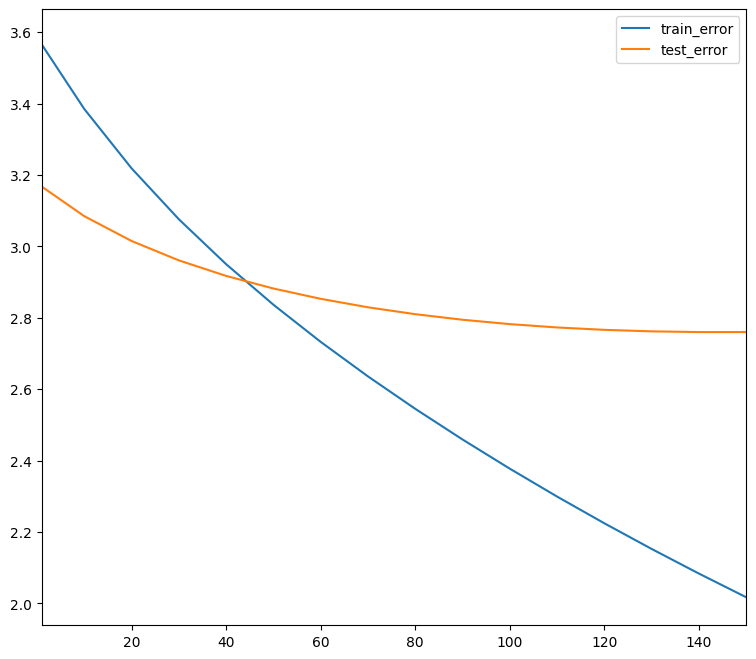

In [255]:
model = build_model(ratings, embedding_dim=40, init_stddev=0.3)
model.train(num_iterations=150, learning_rate=5.)